In [1]:
import os
import numpy as np
os.chdir('../../')
from src.data_loading import LoadCSV
from src.visualization.figure import signal
from src.timedelay_embedding import FindTimeDelay
from src.bifurcation import local_maxima

In [2]:
### Settings

### figure
figure = signal({
        'font.family':'Times New Roman',
        'mathtext.fontset':'stix',
        'font.size':15,
        'xtick.direction':'in',
        'ytick.direction':'in',
        'axes.linewidth':1.5,
        'xtick.major.size':8,
        'ytick.major.size':8,
        }, 
        savefig=False, save_dir='',
        name='', file_type='')

### data loading
CSV_DATA_DIR = './data/vocal_ventricular_flow_rate_change/CSV/'
flow_rate = 40

### spectrogram
stfft_params = {'nperseg': 2000, 'cmap_lim': (-150, 0), 'freq_lim': (0, 500), 'cmap': 'jet'}

In [3]:
def visualization(data_name, steady_range, serch_size, bins):
    ### Load csv
    [time_all, mic_all, flow_all] = LoadCSV(file_path=CSV_DATA_DIR+data_name+'.csv', 
                                            data_name_list=['T', 'MIC', 'FLOW'], 
                                            sample_span=[0, None])
    flow_all *= flow_rate

    ### Figure
    figure.flow_timeseries_spectrogram(time_all, flow_all, mic_all, stfft_params,
                                title='Sound signal', ylabel=r'[V]',
                                ylim_flow=(None, 170), ylim_signal=(-5, 5),
                                steady_range=steady_range)

    ### Steady range
    time, mic, flow = time_all[steady_range[0]:steady_range[-1]], mic_all[steady_range[0]:steady_range[-1]], flow_all[steady_range[0]:steady_range[-1]]
    time -= time[0]
    print('Flow rate: '+str(np.average(flow)))

    ### Find time-delay
    ftd = FindTimeDelay(mic, search_size=serch_size)
    I = ftd.run(bins=bins, return_I=True)
    tau = ftd.result()

    ### Figure
    figure.timeseries_information_delaycoordinate(time, mic, I, tau, n_plt=2000)
    figure.timeseries_attractor_powerspectra(time, mic, tau, n_plt=1000, 
                                             x_lim=[-4.5, 4.5], f_lim=[0, 200], p_lim=[None, 1.3])

Loading csv data
file path | ./data/vocal_ventricular_flow_rate_change/CSV/FVF3_T2.csv
data list | T, MIC, FLOW


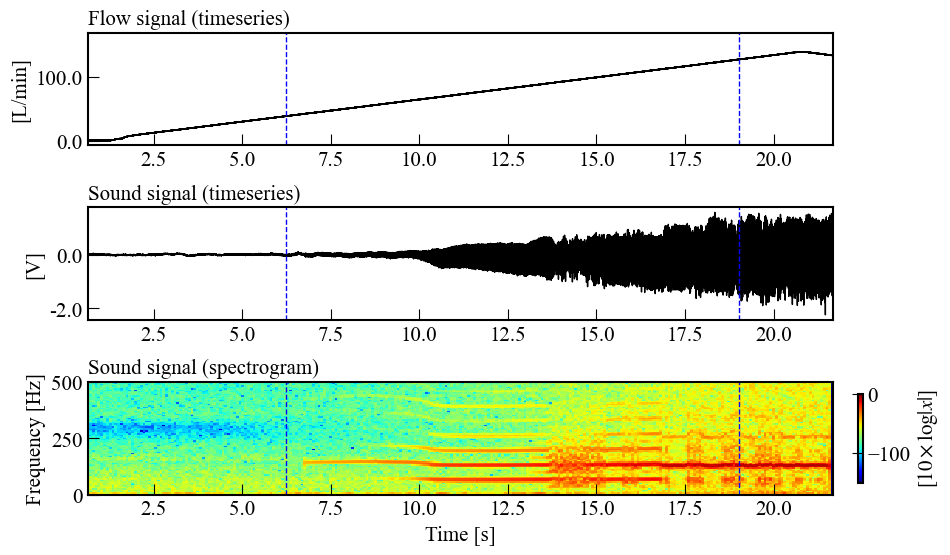

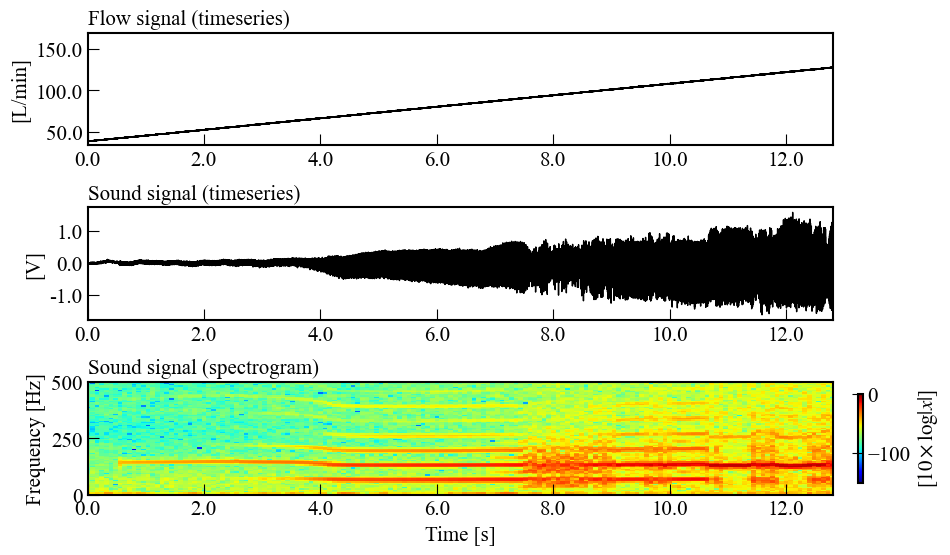

In [52]:
data_name = 'FVF3_T2'
steady_range = [70000, 230000]

### Load csv
[time_all, mic_all, flow_all] = LoadCSV(file_path=CSV_DATA_DIR+data_name+'.csv', 
                                        data_name_list=['T', 'MIC', 'FLOW'], 
                                        sample_span=[0, None])
flow_all *= flow_rate

### Figure
figure.flow_timeseries_spectrogram(time_all, flow_all, mic_all, stfft_params,
                                title='Sound signal', ylabel=r'[V]',
                                ylim_flow=(None, 170), ylim_signal=(None, None),
                                steady_range=steady_range)

time, mic, flow = time_all[steady_range[0]:steady_range[-1]], mic_all[steady_range[0]:steady_range[-1]], flow_all[steady_range[0]:steady_range[-1]]
time -= time[0]
figure.flow_timeseries_spectrogram(time, flow, mic, stfft_params,
                                title='Sound signal', ylabel=r'[V]',
                                ylim_flow=(None, 170), ylim_signal=(None, None),
                                steady_range=[None, None])

In [53]:
parameter_data = flow
signal_data = mic
time_data = time

sample_step = 500

start_points = (np.arange(0, len(signal_data), sample_step)).astype(int)

parameter_list = []
x_list = []
t_list = []

for i in range(len(start_points)):
    parameter_list.append(np.full(len(signal_data[start_points[i]:start_points[i]+sample_step]), np.average(parameter_data[start_points[i]:start_points[i]+sample_step])))
    x_list.append(signal_data[start_points[i]:start_points[i]+sample_step])
    t_list.append(time_data[start_points[i]:start_points[i]+sample_step])

In [54]:
### Get the local-maxima(lm)

x_lm_list, idx_lm_list, p_lm_list, x_lm_flat, idx_lm_flat, p_lm_flat = local_maxima(data_list=x_list,
                                                                                    parameter_list=parameter_list,
                                                                                    standard_scaler=False,
                                                                                    find_peaks_params={'prominence':0.1, 
                                                                                                        'height':0.0, 
                                                                                                        'distance':None, 
                                                                                                        'threshold':None},
                                                                                    return_flatten=True,
                                                                                    savgol_filtering=True,
                                                                                    savgol_filter_params={'window length': 10,
                                                                                                        'polyorder': 1})

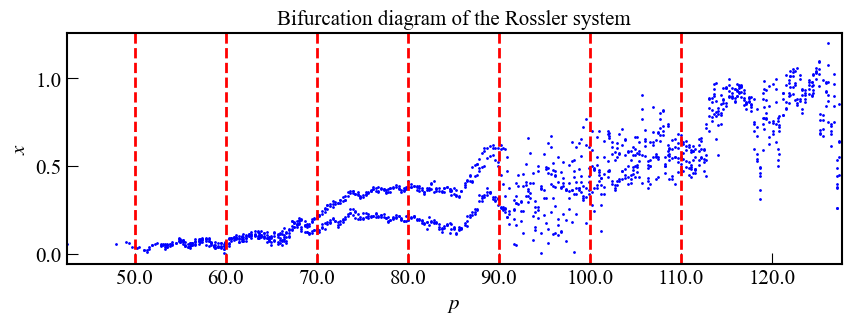

In [55]:
import matplotlib.pylab as plt
from matplotlib import gridspec

parameters = [50, 60, 70, 80, 90, 100, 110]

spec = gridspec.GridSpec(ncols=1, nrows=1, height_ratios=[1], hspace=0)
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(spec[0])
ax.set_title('Bifurcation diagram of the Rossler system', loc='center', fontsize=plt.rcParams['font.size'])
ax.scatter(p_lm_flat, x_lm_flat, s=1, c='b')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$x$')
ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_xlim(p_lm_flat[0], p_lm_flat[-1])
for p in parameters: ax.axvline(x=p, linestyle='--', c='r', lw=2)

plt.show()

(42.5114990234375, 127.6596923828125)

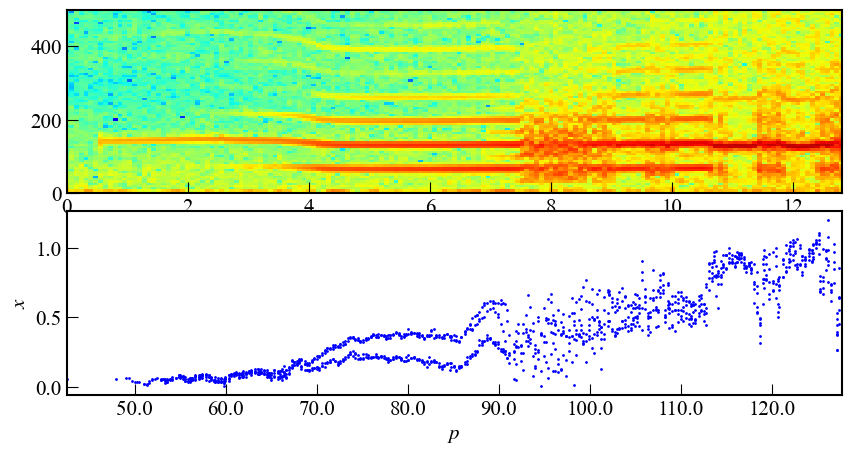

In [57]:
from src.util import short_time_ft

spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1, 1], hspace=0.1)
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(spec[0])
#ax.set_title(title+' (spectrogram)', loc='left', fontsize=plt.rcParams['font.size'])
dt = time[1] - time[0]
freq, t_stft, intens = short_time_ft(mic, dt, stfft_params['nperseg'])
p = np.linspace(time[0], time[-1], t_stft.shape[0])
power = 10*np.log(np.abs(intens))
img = ax.pcolormesh(p, freq, power, cmap=stfft_params['cmap'], vmin=stfft_params['cmap_lim'][0], vmax=stfft_params['cmap_lim'][1])
ax.set_xlim(time[0], time[-1])
ax.set_ylim(stfft_params['freq_lim'])
#ax.set_xlabel(xlabel)

ax = fig.add_subplot(spec[1])
#ax.set_title('Bifurcation diagram of the Rossler system', loc='center', fontsize=plt.rcParams['font.size'])
ax.scatter(p_lm_flat, x_lm_flat, s=1, c='b')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$x$')
ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.set_xlim(p_lm_flat[0], p_lm_flat[-1])

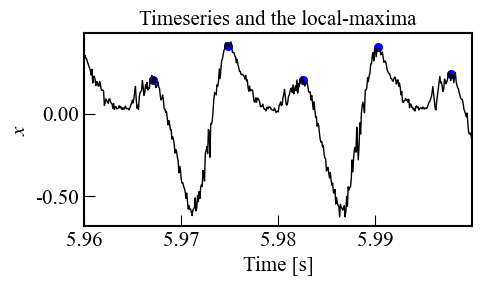

In [59]:
p = parameters[3]
plt_num = -1

P = []
for i in parameter_list: P.append(i[0])
p_idx = np.argmin(np.abs(np.array(P) - p))

spec = gridspec.GridSpec(ncols=1, nrows=1, )
fig = plt.figure(figsize=(5, 2.5))

#x = x_list[p_idx] / np.std(x_list[p_idx])
x = x_list[p_idx]

ax = fig.add_subplot(spec[0])
ax.set_title('Timeseries and the local-maxima', loc='center', fontsize=plt.rcParams['font.size'])
ax.plot(t_list[p_idx], x, lw=1, c='k')
ax.scatter(t_list[p_idx][idx_lm_list[p_idx]], x[idx_lm_list[p_idx]], s=30, c='b')
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'$x$')
ax.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax.get_yaxis().set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax.set_xlim(t_list[p_idx][0], t_list[p_idx][plt_num])

plt.show()